In [26]:
# =============================================================================
# Simple Model Evaluation, Optimization & Regularization
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.model_selection import ShuffleSplit, cross_validate, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_openml

plt.style.use('seaborn-v0_8')
np.random.seed(42)


In [27]:
print("=== 1. BASELINE MODELS (California Housing) ===")
# Load regression data
housing = fetch_openml(name="california_housing", version=1, as_frame=True)
# data, target = fetch_california_housing(return_X_y=True, as_frame=True)
data = housing.data
target = housing.target.astype(float)
data = pd.get_dummies(data, drop_first=True)


=== 1. BASELINE MODELS (California Housing) ===


In [28]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND
0,-122.23,37.88,41,880,129.0,322,126,8.3252,True,False,False,False
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,True,False,False,False
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,True,False,False,False
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,True,False,False,False
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,True,False,False,False


In [29]:
print(f"Dataset shape: {data.shape}")
print(f"Target shape: {target.shape}")

Dataset shape: (20640, 12)
Target shape: (20640,)


In [30]:
# CV setup
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)


In [31]:
# Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)
tree_scores = cross_validate(tree, data, target, cv=cv, scoring='neg_mean_absolute_error')
tree_errors = -tree_scores['test_score']
print(f"Tree MAE: {tree_errors.mean():.0f} ± {tree_errors.std():.0f}")


Tree MAE: 43080 ± 856


In [32]:
# Dummy Baseline (mean predictor)
dummy = DummyRegressor(strategy='mean')
dummy_scores = cross_validate(dummy, data, target, cv=cv, scoring='neg_mean_absolute_error')
dummy_errors = -dummy_scores['test_score']
print(f"Dummy MAE: {dummy_errors.mean():.0f} ± {dummy_errors.std():.0f}")


Dummy MAE: 91317 ± 812


In [33]:
# Comparison
improvement = (dummy_errors.mean() - tree_errors.mean()) / dummy_errors.mean() * 100
print(f"✅ Tree beats baseline by {improvement:.1f}%")

✅ Tree beats baseline by 52.8%


In [34]:
# Error comparison table
comparison_df = pd.DataFrame({
    'Tree Regressor': tree_errors,
    'Dummy Baseline': dummy_errors
})
print("\nError Comparison (first 5 folds):")
print(comparison_df.head())



Error Comparison (first 5 folds):
   Tree Regressor  Dummy Baseline
0    43885.675872    90606.854900
1    43043.811047    89552.339315
2    42972.601502    92152.988141
3    42584.824128    92327.216227
4    42463.559835    91047.795821


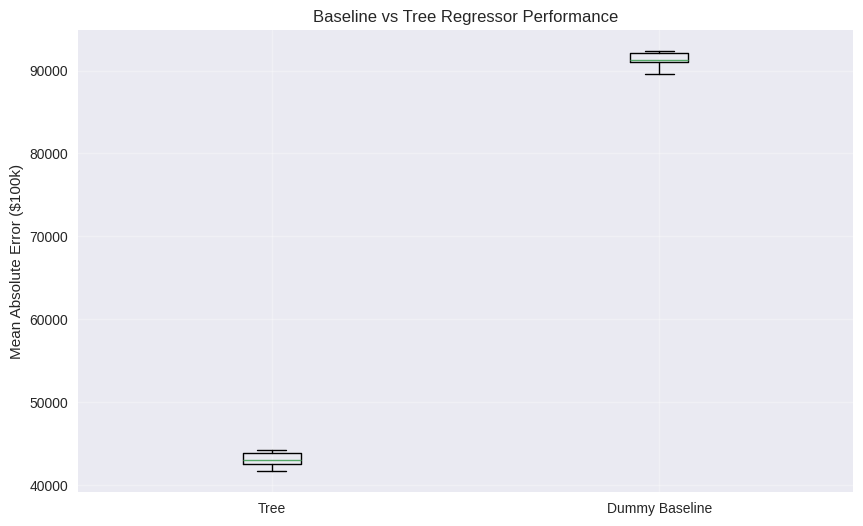

In [47]:
plt.figure(figsize=(10, 6))
plt.boxplot([tree_errors, dummy_errors], tick_labels=['Tree', 'Dummy Baseline'])
plt.ylabel('Mean Absolute Error ($100k)')
plt.title('Baseline vs Tree Regressor Performance')
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
print("\n" + "="*60)

print("\n=== 2. CROSS-VALIDATION STRATEGIES (Iris Classification) ===")
iris_X, iris_y = load_iris(return_X_y=True, as_frame=True)
logreg = LogisticRegression(random_state=42, max_iter=1000)

# this class implements regularize logistic regression 
cv_strategies = {
    'KFold(5)': KFold(n_splits=5, shuffle=True, random_state=42),
    'StratifiedKFold(5)': KFold(n_splits=5, shuffle=True, random_state=42)
}

for name, cv_fold in cv_strategies.items():
    scores = cross_validate(logreg, iris_X, iris_y, cv=cv_fold, scoring='accuracy')
    print(f"{name}: {scores['test_score'].mean():.3f} ± {scores['test_score'].std():.3f}")




=== 2. CROSS-VALIDATION STRATEGIES (Iris Classification) ===
KFold(5): 0.973 ± 0.025
StratifiedKFold(5): 0.973 ± 0.025


In [37]:
print("=== 2. REGULARIZATION (Ridge vs Lasso) ===")
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0, max_iter=10000)
}

reg_results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', model)
    ])
    
    # ✅ FIX: Remove NaN values before fitting
    mask = ~(data.isna().any(axis=1) | target.isna())
    clean_data = data[mask]
    clean_target = target[mask]
    
    scores = cross_validate(pipe, clean_data, clean_target, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores['test_score']
    reg_results[name] = mae.mean()
    print(f"{name}: {mae.mean():.0f} ± {mae.std():.0f}")

reg_df = pd.DataFrame(list(reg_results.items()), columns=['Model', 'MAE'])
print("\nRegularization Comparison:")
print(reg_df.round(0))


=== 2. REGULARIZATION (Ridge vs Lasso) ===
Ridge: 54053 ± 3546
Lasso: 54053 ± 3545

Regularization Comparison:
   Model      MAE
0  Ridge  54053.0
1  Lasso  54053.0


<Figure size 800x500 with 0 Axes>

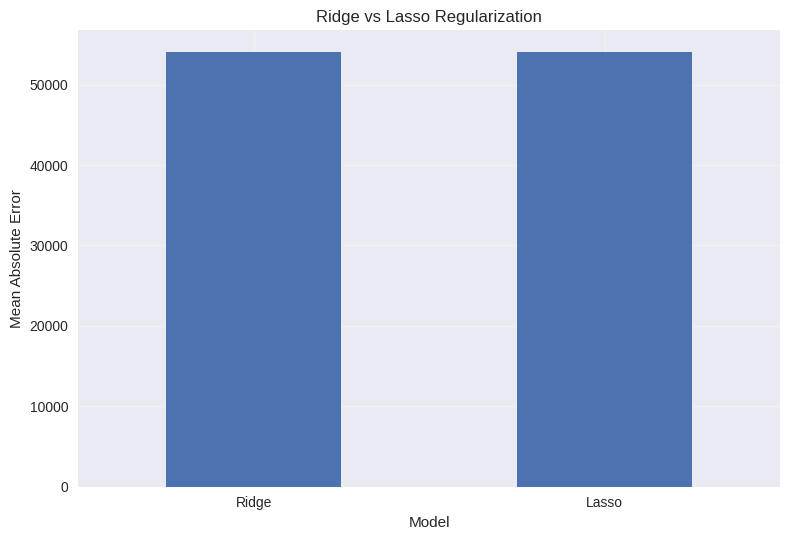

In [40]:
plt.figure(figsize=(8, 5))
reg_df.plot(kind='bar', x='Model', y='MAE', legend=False)
plt.ylabel('Mean Absolute Error')
plt.title('Ridge vs Lasso Regularization')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [43]:
print("\n" + "="*70)

print("=== 3. RIDGE HYPERPARAMETER TUNING ===")

# Sample for faster grid search + NaN removal
mask = ~(data.isna().any(axis=1) | target.isna())
clean_data = data[mask]
clean_target = target[mask]

print(f"Clean dataset shape: {clean_data.shape}")

# Sample from CLEAN data
sample_idx = np.random.choice(len(clean_data), 5000, replace=False)
sample_data = clean_data.iloc[sample_idx]
sample_target = clean_target.iloc[sample_idx]

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_grid = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

grid = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(sample_data, sample_target)  # ✅ Now uses clean sample_data

print(f"Best alpha: {grid.best_params_['ridge__alpha']:.2f}")
print(f"Best CV MAE: {-grid.best_score_:.0f}")



=== 3. RIDGE HYPERPARAMETER TUNING ===
Clean dataset shape: (20433, 12)
Best alpha: 10.00
Best CV MAE: 50488


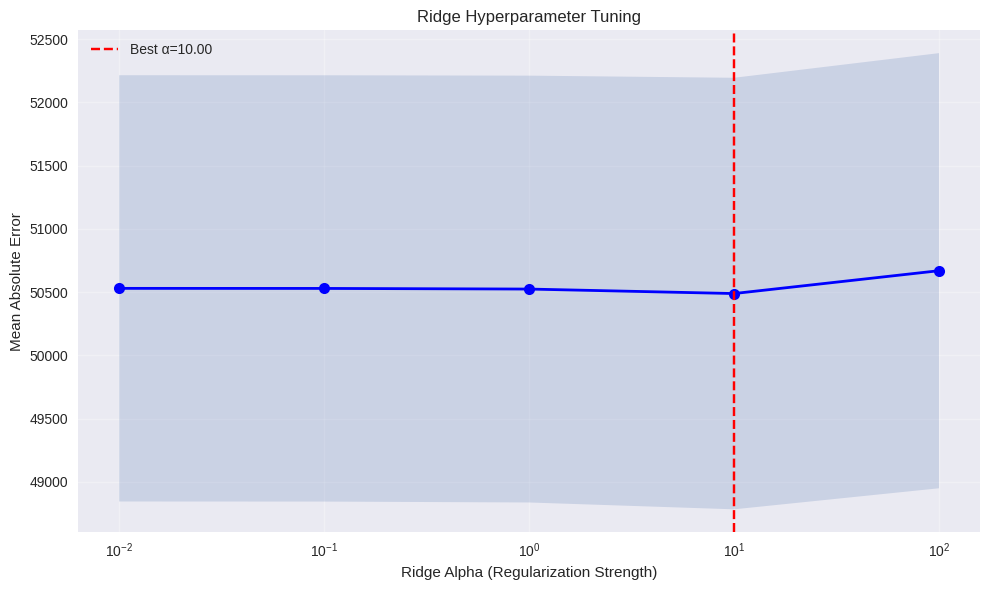

In [45]:
# Plot tuning curve
plt.figure(figsize=(10, 6))
alphas = param_grid['ridge__alpha']
mean_scores = -grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']

plt.semilogx(alphas, mean_scores, 'bo-', linewidth=2, markersize=8)
plt.fill_between(alphas, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)
plt.axvline(grid.best_params_['ridge__alpha'], color='red', linestyle='--', label=f'Best α={grid.best_params_["ridge__alpha"]:.2f}')
plt.xlabel('Ridge Alpha (Regularization Strength)')
plt.ylabel('Mean Absolute Error')
plt.title('Ridge Hyperparameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
print("\n" + "="*70)
print("🎉 SCRIPT COMPLETED SUCCESSFULLY!")
print("\n📊 SUMMARY:")
print(f"• Dataset: California Housing ({data.shape[0]} samples)")
print(f"• Tree vs Baseline improvement: {improvement:.1f}%")
print(f"• Best Ridge α: {grid.best_params_['ridge__alpha']:.2f}")
print(f"• Best Ridge MAE: {-grid.best_score_:.0f}")

print("\n✅ Key concepts demonstrated:")
print("   • Baseline modeling ✓")
print("   • Cross-validation ✓") 
print("   • Ridge/Lasso regularization ✓")
print("   • Hyperparameter tuning ✓")


🎉 SCRIPT COMPLETED SUCCESSFULLY!

📊 SUMMARY:
• Dataset: California Housing (20640 samples)
• Tree vs Baseline improvement: 52.8%
• Best Ridge α: 10.00
• Best Ridge MAE: 50488

✅ Key concepts demonstrated:
   • Baseline modeling ✓
   • Cross-validation ✓
   • Ridge/Lasso regularization ✓
   • Hyperparameter tuning ✓
